<a href="https://colab.research.google.com/github/Anze-/datathon2k25/blob/alberto/feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering

# 1. Set up working environment

In [297]:
import pandas as pd
import numpy as np
import csv

In [240]:
# enable GPU if needed, GPU can speed up your vector embedding if you computing these vectors locally (not using API)

import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [241]:
import os
import json
import chromadb
import openai
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA

# Set OpenAI API Key
os.environ["OPENAI_API_KEY"] = open('api.key').read()[:-1]

# 2. Knowledge Base Preparation

## 2.1 World Cities

In [242]:
cities_path = './data/geonames-all-cities-with-a-population-1000.csv'
cdb = pd.read_csv(cities_path, sep=';', header=0)

In [243]:
cdb[~pd.isna(cdb['Alternate Names'])] 

,Geoname ID,Name,ASCII Name,Alternate Names,Feature Class,Feature Code,Country Code,Country name EN,Country Code 2,Admin1 Code,Admin2 Code,Admin3 Code,Admin4 Code,Population,Elevation,DIgital Elevation Model,Timezone,Modification date,LABEL EN,Coordinates
0,3948841,Huayllati,Huayllati,"Huaillati,Huayllati",P,PPLA3,PE,Peru,NaN,03,0307,030704,NaN,515,NaN,3467,America/Lima,2020-05-13,Peru,"-13.92862, -72.48496"
6,2093967,Kimbe,Kimbe,"Kimbe,jin bei,kymbh,Кимбе,کمبے,کیمبه,金貝",P,PPLA,PG,Papua New Guinea,NaN,17,NaN,NaN,NaN,18847,NaN,27,Pacific/Port_Moresby,2015-04-06,Papua New Guinea,"-5.55085, 150.13766"
7,1680116,NIA Valencia,NIA Valencia,"Dakbayan sa Valencia,Kota Valencia,Lungsod ng ...",P,PPL,PH,Philippines,NaN,10,12,101321000,NaN,83591,NaN,310,Asia/Manila,2022-02-15,Philippines,"7.90639, 125.09417"
8,1680216,Upper Klinan,Upper Klinan,Upper Klinan,P,PPL,PH,Philippines,NaN,12,70,126312000,NaN,3768,NaN,288,Asia/Manila,2017-12-13,Philippines,"6.22722, 125.12083"
9,1680275,Unidos,Unidos,Unidos,P,PPL,PH,Philippines,NaN,10,42,104212000,NaN,2111,NaN,37,Asia/Manila,2017-12-13,Philippines,"8.5942, 123.668"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147019,2293089,Akréby,Akreby,"Akrebi,Akreby,Akrébi,Akréby",P,PPL,CI,Côte d'Ivoire,NaN,94,NaN,NaN,NaN,3557,NaN,111,Africa/Abidjan,2023-12-21,Côte d'Ivoire,"6.14352, -3.38539"
147022,2293516,Obodroupa,Obodroupa,"Abodioupa,Obodroupa",P,PPL,CI,Côte d'Ivoire,NaN,95,NaN,NaN,NaN,2676,NaN,244,Africa/Abidjan,2023-12-22,Côte d'Ivoire,"6.0444, -5.79622"
147023,2293534,Adiékro,Adiekro,"Abiekro,Abiékro,Adiekro,Adiékro",P,PPL,CI,Côte d'Ivoire,NaN,90,NaN,NaN,NaN,2090,NaN,334,Africa/Abidjan,2023-12-23,Côte d'Ivoire,"7.79953, -5.19611"
147026,2596928,Gbéssé,Gbesse,"Besse,Béssé,Gbesse,Gbéssé",P,PPL,CI,Côte d'Ivoire,NaN,82,NaN,NaN,NaN,2376,NaN,34,Africa/Abidjan,2023-12-22,Côte d'Ivoire,"5.8394, -4.29264"


<Axes: >

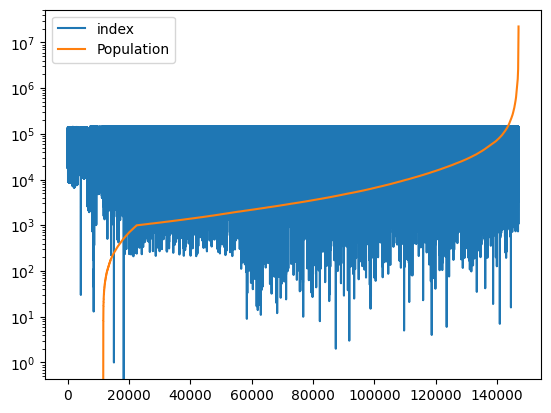

In [244]:
cdb.sort_values('Population').Population.reset_index().plot(logy=True) # elbow cut @ 20k inhabitants

<Axes: >

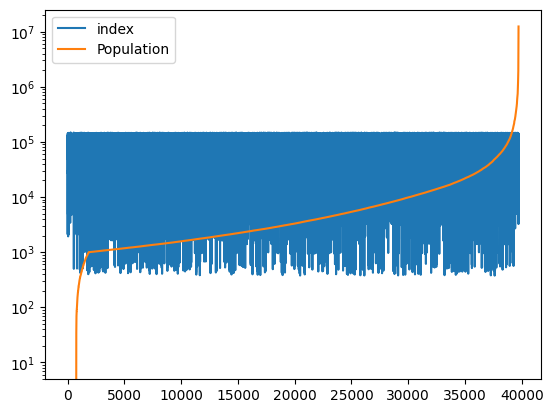

In [245]:
#US Only market
cdb[cdb['Country Code'].isin(['US','PA','MX','CA','GB','AU', 'IE', 'BR', 'CH'])].sort_values('Population').Population.reset_index().plot(logy=True) # elbow cut @ 2k inhabitants isn't worth it

In [246]:
#cities of interest:
cof = cdb[cdb['Country Code'].isin(['US','PA','MX','CA','GB','AU', 'IE', 'BR', 'CH'])]
cof = cof[cof['Population']>10000]

In [247]:
cof[cof.Name=='Newark'][['Name','Admin1 Code']]

,Name,Admin1 Code
954,Newark,DE
28123,Newark,OH
52466,Newark,NJ
84104,Newark,CA


## 2.2 US Cities

In [248]:
cities_path = './data/us-cities-demographics.csv'
usc = pd.read_csv(cities_path, sep=';', header=0)


In [288]:
USCODES = usc['State Code'].unique()

In [249]:
usc = usc[['City','State Code','Median Age','Male Population','Female Population','Foreign-born']].drop_duplicates()

In [250]:
merged_df = pd.merge(
    cof,
    usc,
    left_on=['Name', 'Admin1 Code'],
    right_on=['City', 'State Code'],
    how='left'
)

In [251]:
geo_df = merged_df[['ASCII Name', 'Alternate Names', 'Feature Class',
       'Feature Code', 'Country Code',
       'Admin1 Code', 'Population', 'Elevation','Timezone', 'Coordinates', 'City', 'State Code',
       'Median Age', 'Male Population', 'Female Population', 'Foreign-born']]

blacklist = ['Enterprise','Summit','Justice',"Mobile","Opportunity","Mission","Orange","March","Central"]


for wrd in blacklist:
    geo_df = geo_df[geo_df['ASCII Name']!=wrd]

## 2.3 Feature extraction

In [252]:
folder_path = "./data/hackathon_data/"# Google drive path of the dataset
files_in_folder = os.listdir(folder_path)
len(files_in_folder)

13144

In [253]:
def load_documents(json_file):
    """Loads the JSON file."""
    with open(json_file, 'r') as f:
      try:
          data = json.load(f)
          return data
      except json.JSONDecodeError:
          print(f"Error reading {json_file}, it may not be a valid JSON file.")
    return []

In [294]:
def load_text(file=files_in_folder[0]):
    print(file)
    urldocs=load_documents(folder_path+file)['text_by_page_url']
    return urldocs.values()

In [293]:
import re
from concurrent.futures import ThreadPoolExecutor
from typing import List, Tuple
from tqdm import tqdm

# City list
cities = geo_df['ASCII Name'].values
cities_set = set(city.lower() for city in cities)

# Regex for Title Case OR ALL CAPS
pattern = re.compile(
    r'\b(?:' +
    '|'.join(
        rf'{re.escape(city.title())}|{re.escape(city.upper())}'
        for city in cities_set
    ) +
    r')\b'
)

# Match function — now returns position too
def contains_city(text: str) -> Tuple[bool, str, int]:
    match = pattern.search(text)
    if match:
        return True, match.group(0), match.start()
    return False, "", -1

# ✅ You asked to keep this unchanged — still works perfectly
def process_documents(documents: List[str], max_workers: int = 4):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        return list(tqdm(executor.map(contains_city, documents), total=len(documents), desc="Processing Docs"))

# Example documents
docs = load_text()

# Run it
results = process_documents(docs)

# Output results
found_cities = []
contexts = {}
for doc, (found, city, pos) in zip(docs, results):
    if found:
        found_cities.append(city)
        if city in contexts.keys(): # add context
            contexts[city] = contexts[city]+' '+doc[pos:pos+30]
        else: #create context
            contexts[city] = doc[pos:pos+30]
        #print(f"{city}, Context: {doc[pos:pos+30]}")

found_cities = np.array(found_cities)

# Get unique values and their counts
cvalues, ccounts = np.unique(found_cities, return_counts=True)

# Find the most frequent (mode)

most_frequent = cvalues[np.argmax(ccounts)]
top_context = contexts[most_frequent]


# Now check if in the context

# Build regex to match full words (case-sensitive)
pattern = re.compile(r'\b(?:' + '|'.join(re.escape(code) for code in USCODES) + r')\b')

# Find all matches
code_matches = pattern.findall(top_context)

# Find the most frequent one
if code_matches:
    values, counts = np.unique(code_matches, return_counts=True)
    found_state = values[np.argmax(counts)]
else:
    found_state = None

print(f'we are in {most_frequent}, {found_state}')

skysolutions.com.json




Processing Docs:   0%|                                              | 0/70 [00:00<?, ?it/s]

Processing Docs:  73%|██████████████████████████▏         | 51/70 [00:01<00:00, 179.27it/s]

Processing Docs: 100%|█████████████████████████████████████| 70/70 [00:01<00:00, 40.73it/s]

we are in Herndon, VA


## Now run it on the dataset

In [330]:
cities = geo_df['ASCII Name'].values
cities_set = set(city.lower() for city in cities)

def extract_location(baseurl=files_in_folder[0],max_workers=4,disabletqdm=True):
    # Documents
    docs = load_text(file=baseurl)
    
    # City list
    
    # Regex for Title Case OR ALL CAPS
    pattern = re.compile(
        r'\b(?:' +
        '|'.join(
            rf'{re.escape(city.title())}|{re.escape(city.upper())}'
            for city in cities_set
        ) +
        r')\b'
    )
    
    # Match function — now returns position too
    def contains_city(text: str) -> Tuple[bool, str, int]:
        match = pattern.search(text)
        if match:
            return True, match.group(0), match.start()
        return False, "", -1
    
    def process_documents(documents: List[str], max_workers: int = 4):
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            return list(tqdm(executor.map(contains_city, documents), total=len(documents), desc="Processing Docs", disable=disabletqdm))
    
    # Run it
    results = process_documents(docs,max_workers=max_workers)
    
    # Output results
    found_cities = []
    contexts = {}
    for doc, (found, city, pos) in zip(docs, results):
        if found:
            found_cities.append(city)
            if city in contexts.keys(): # add context
                contexts[city] = contexts[city]+' '+doc[pos:pos+30]
            else: #create context
                contexts[city] = doc[pos:pos+30]
            #print(f"{city}, Context: {doc[pos:pos+30]}")
    
    found_cities = np.array(found_cities)
    
    # Get unique values and their counts
    cvalues, ccounts = np.unique(found_cities, return_counts=True)

    if len(ccounts) == 0:
        return {'city':None, 'state':None, 'context':None}
        
    # Find the most frequent (mode)
    most_frequent = cvalues[np.argmax(ccounts)]
    top_context = contexts[most_frequent]
    
    
    # Now check if in the context
  
    # Build regex to match full words (case-sensitive)
    pattern = re.compile(r'\b(?:' + '|'.join(re.escape(code) for code in USCODES) + r')\b')
    
    # Find all matches
    code_matches = pattern.findall(top_context)
    
    # Find the most frequent one
    if code_matches:
        values, counts = np.unique(code_matches, return_counts=True)
        found_state = values[np.argmax(counts)]
    else:
        found_state = None
    
    return {'city':most_frequent, 'state':found_state, 'context':top_context}

In [331]:
len(geo_df[geo_df['Elevation']==-1000])

0

In [ ]:
for file in tqdm(files_in_folder[67:]):
    info = extract_location(baseurl=file,max_workers=30)
    geodata = geo_df[(geo_df['ASCII Name']==info['city']) & (geo_df['Admin1 Code']==info['state'])]
    if len(geodata)==0:
        with open('./data/geofeature.csv', mode='a', newline='') as geo_out:
            writer = csv.writer(geo_out)
            writer.writerow([file,len(geodata),info['context']])
    else:
        with open('./data/geofeature.csv', mode='a', newline='') as geo_out:
            writer = csv.writer(geo_out)
            writer.writerow([file,len(geodata),geodata.to_json()])




  0%|                                                            | 0/13077 [00:00<?, ?it/s]

affinityhealthcorp.com.json
stadiumpeople.com.json





  0%|                                                  | 2/13077 [00:00<1:00:38,  3.59it/s]

gannettfleming.com.json





  0%|                                                 | 3/13077 [00:08<12:59:56,  3.58s/it]

imigroup.com.json





  0%|                                                 | 4/13077 [00:15<17:02:13,  4.69s/it]

trustapexinternational.com.json





  0%|                                                 | 5/13077 [00:25<24:03:55,  6.63s/it]

lumapps.com.json





  0%|                                                 | 6/13077 [00:34<26:25:42,  7.28s/it]

cardinals.com.json
revisionenergy.com.json





  0%|                                                 | 8/13077 [00:34<13:53:57,  3.83s/it]

guthy-renker.com.json





  0%|                                                 | 9/13077 [00:42<17:44:23,  4.89s/it]

marqeta.com.json





  0%|                                                | 10/13077 [00:53<23:47:00,  6.55s/it]

mechatronics.com.json





  0%|                                                | 11/13077 [01:00<24:24:12,  6.72s/it]

rewterz.com.json





  0%|                                                | 12/13077 [01:21<38:57:04, 10.73s/it]

tektonlabs.com.json





  0%|                                                | 13/13077 [01:24<30:30:38,  8.41s/it]

georgetowncommunityhospital.com.json





  0%|                                                | 14/13077 [01:29<26:44:40,  7.37s/it]

sterlingequities.com.json





  0%|                                                | 15/13077 [01:30<20:15:09,  5.58s/it]

coverwallet.com.json





  0%|                                                | 16/13077 [01:37<22:20:00,  6.16s/it]

holyspiritretirementhome.com.json





  0%|                                                | 17/13077 [01:58<37:29:58, 10.34s/it]

senecaglobal.com.json





  0%|                                                | 18/13077 [02:08<37:58:22, 10.47s/it]

rwcatskills.com.json





  0%|                                                | 19/13077 [02:09<26:52:20,  7.41s/it]

emersonrogers.com.json





  0%|                                                | 20/13077 [02:17<27:28:50,  7.58s/it]

neogenomics.com.json





  0%|                                                | 21/13077 [02:17<19:41:12,  5.43s/it]

cctvcamerapros.com.json





  0%|                                                | 22/13077 [02:25<22:05:52,  6.09s/it]

thevillageshealth.com.json





  0%|                                                | 23/13077 [02:36<27:53:19,  7.69s/it]

cjadvertising.com.json





  0%|                                                | 24/13077 [02:42<26:04:21,  7.19s/it]

engageware.com.json





  0%|                                                | 25/13077 [02:54<30:47:22,  8.49s/it]

cbservice.com.json
conceptrehab.com.json





  0%|                                                | 27/13077 [02:58<19:50:46,  5.47s/it]

answernet.com.json





  0%|                                                | 28/13077 [03:11<27:09:31,  7.49s/it]

s2cp.com.json





  0%|                                                | 29/13077 [03:13<22:02:36,  6.08s/it]

montessorieducation.com.json





  0%|                                                | 30/13077 [03:16<18:54:50,  5.22s/it]

inspire11.com.json





  0%|                                                | 31/13077 [03:29<26:26:59,  7.30s/it]

arvinas.com.json





  0%|                                               | 32/13077 [04:55<107:37:49, 29.70s/it]

constellationmutual.com.json
aaitpro.com.json





  0%|                                                | 34/13077 [05:06<68:38:45, 18.95s/it]

citimed.com.json





  0%|▏                                               | 35/13077 [05:14<59:14:37, 16.35s/it]

virginiamedia.com.json





  0%|▏                                               | 36/13077 [05:45<72:25:47, 19.99s/it]

neevsystems.com.json





  0%|▏                                               | 37/13077 [05:59<67:13:05, 18.56s/it]

66degrees.com.json





  0%|▏                                               | 38/13077 [06:11<60:03:34, 16.58s/it]

evonsys.com.json





  0%|▏                                               | 39/13077 [06:32<64:09:32, 17.72s/it]

imta.com.json





  0%|▏                                               | 40/13077 [06:39<53:35:22, 14.80s/it]

chowbus.com.json





  0%|▏                                               | 41/13077 [06:41<39:44:15, 10.97s/it]

julyservices.com.json





  0%|▏                                               | 42/13077 [06:47<34:45:42,  9.60s/it]

benhamouglobalventures.com.json





  0%|▏                                               | 43/13077 [06:49<26:23:55,  7.29s/it]

ccok.com.json





  0%|▏                                               | 44/13077 [06:52<22:11:01,  6.13s/it]

alamoanahotelhonolulu.com.json





  0%|▏                                               | 45/13077 [06:53<16:20:47,  4.52s/it]

mooretransport.com.json





  0%|▏                                               | 46/13077 [06:53<11:45:38,  3.25s/it]

usfertility.com.json





  0%|▏                                               | 47/13077 [06:55<10:32:26,  2.91s/it]

marionso.com.json
ucco.com.json





  0%|▏                                               | 49/13077 [07:04<13:00:31,  3.59s/it]

wolffolins.com.json





  0%|▏                                               | 50/13077 [07:08<12:49:39,  3.54s/it]

revionics.com.json





  0%|▏                                               | 51/13077 [07:18<19:05:36,  5.28s/it]

epiloglaser.com.json





  0%|▏                                               | 52/13077 [07:18<14:06:27,  3.90s/it]

sram.com.json





  0%|▏                                               | 53/13077 [07:19<10:51:47,  3.00s/it]

purvis.com.json





  0%|▏                                               | 54/13077 [07:29<18:23:11,  5.08s/it]

freshgravity.com.json





  0%|▏                                               | 55/13077 [07:35<19:52:15,  5.49s/it]

issaction.com.json





  0%|▏                                               | 56/13077 [07:40<18:47:17,  5.19s/it]

littletongroup.com.json





  0%|▏                                               | 57/13077 [07:41<14:27:57,  4.00s/it]

mainline.com.json





  0%|▏                                               | 58/13077 [07:54<24:13:25,  6.70s/it]

choate.com.json





  0%|▏                                               | 59/13077 [07:59<22:10:45,  6.13s/it]

c2spr.com.json





  0%|▏                                               | 60/13077 [08:05<22:30:29,  6.22s/it]

modjeski.com.json





  0%|▏                                               | 61/13077 [08:15<26:26:29,  7.31s/it]

duplionline.com.json





  0%|▏                                               | 62/13077 [08:16<19:17:51,  5.34s/it]

adesisinc.com.json





  0%|▏                                               | 63/13077 [08:24<22:06:20,  6.11s/it]

unitedpower.com.json





  0%|▏                                               | 64/13077 [08:26<17:32:30,  4.85s/it]


  0%|▏                                               | 65/13077 [08:26<12:27:19,  3.45s/it]

gitano.com.json
simondata.com.json





  1%|▏                                               | 66/13077 [08:27<10:16:03,  2.84s/it]

engagestar.com.json





  1%|▏                                               | 67/13077 [08:47<27:52:55,  7.72s/it]

silaservices.com.json





  1%|▏                                               | 68/13077 [08:50<22:59:57,  6.36s/it]

fpacp.com.json





  1%|▎                                               | 69/13077 [08:55<21:45:54,  6.02s/it]

alpha-sense.com.json





  1%|▎                                               | 70/13077 [08:57<17:52:17,  4.95s/it]

harveyssupermarkets.com.json





  1%|▎                                               | 71/13077 [09:13<29:56:15,  8.29s/it]

alcivia.com.json





  1%|▎                                               | 72/13077 [09:24<32:16:23,  8.93s/it]

rlginc.com.json





  1%|▎                                               | 73/13077 [09:26<24:33:54,  6.80s/it]

buildgc.com.json





  1%|▎                                               | 74/13077 [09:30<21:48:37,  6.04s/it]

beekley.com.json





  1%|▎                                               | 75/13077 [09:41<26:43:39,  7.40s/it]

imperfect.com.json
combinedtransport.com.json





  1%|▎                                               | 77/13077 [09:44<17:33:04,  4.86s/it]

nsre.com.json





  1%|▎                                               | 78/13077 [09:54<21:50:39,  6.05s/it]

iengineering.com.json





  1%|▎                                               | 79/13077 [09:59<21:06:32,  5.85s/it]

mimeridian.com.json





  1%|▎                                               | 80/13077 [10:01<17:27:44,  4.84s/it]

canuscorp.com.json





  1%|▎                                               | 81/13077 [10:07<18:26:11,  5.11s/it]

wvmb.com.json





  1%|▎                                               | 82/13077 [10:08<13:39:51,  3.79s/it]

corexpartners.com.json





  1%|▎                                               | 83/13077 [10:26<29:03:47,  8.05s/it]

flatrivergroup.com.json





  1%|▎                                               | 84/13077 [10:32<26:17:42,  7.29s/it]

walshbrothers.com.json





  1%|▎                                               | 85/13077 [10:41<29:00:22,  8.04s/it]

dashlane.com.json





  1%|▎                                               | 86/13077 [10:49<28:55:07,  8.01s/it]

colsongroup.com.json





  1%|▎                                               | 87/13077 [10:54<25:42:40,  7.13s/it]

tilebar.com.json





  1%|▎                                               | 88/13077 [10:55<18:52:05,  5.23s/it]

concerthealth.com.json





  1%|▎                                               | 89/13077 [10:58<16:38:59,  4.62s/it]

tuckeralbin.com.json
aprco.com.json





  1%|▎                                               | 91/13077 [11:15<23:00:52,  6.38s/it]

maxwellkates.com.json





  1%|▎                                               | 92/13077 [11:29<29:21:12,  8.14s/it]

theviswagroup.com.json





  1%|▎                                               | 93/13077 [11:33<25:46:19,  7.15s/it]

e360.com.json





  1%|▎                                               | 94/13077 [11:44<29:15:32,  8.11s/it]

cardinalstaffing.com.json





  1%|▎                                               | 95/13077 [11:51<28:09:43,  7.81s/it]

precisionglobal.com.json





  1%|▎                                              | 96/13077 [15:02<216:46:53, 60.12s/it]

cottoninc.com.json





  1%|▎                                              | 97/13077 [15:04<155:41:53, 43.18s/it]

spectratechinc.com.json





  1%|▎                                              | 98/13077 [15:09<116:20:49, 32.27s/it]

alphaconsulting.com.json





  1%|▎                                              | 99/13077 [15:29<103:01:56, 28.58s/it]

mellottcompany.com.json





  1%|▎                                              | 100/13077 [15:34<77:30:19, 21.50s/it]

acelerolearning.com.json





  1%|▎                                              | 101/13077 [15:37<58:12:00, 16.15s/it]

fontainemodification.com.json





  1%|▎                                              | 102/13077 [15:38<41:15:28, 11.45s/it]

healthmark-group.com.json





  1%|▎                                              | 103/13077 [15:56<48:42:51, 13.52s/it]

dedicatednurses.com.json





  1%|▎                                              | 104/13077 [16:02<40:30:18, 11.24s/it]

gubagoo.com.json





  1%|▍                                              | 105/13077 [16:11<38:14:44, 10.61s/it]

cancapital.com.json





  1%|▍                                              | 106/13077 [16:15<31:17:39,  8.69s/it]

hansoll.com.json





  1%|▍                                              | 107/13077 [16:26<33:13:39,  9.22s/it]

advisenltd.com.json





  1%|▍                                              | 108/13077 [16:34<31:40:34,  8.79s/it]

ftxcs.com.json





  1%|▍                                              | 109/13077 [17:00<50:07:42, 13.92s/it]

tfeconnect.com.json





  1%|▍                                              | 110/13077 [17:09<45:03:25, 12.51s/it]

teamavoq.com.json





  1%|▍                                              | 111/13077 [17:24<48:23:09, 13.43s/it]

portcanaveral.com.json





  1%|▍                                              | 112/13077 [17:27<36:24:18, 10.11s/it]


  1%|▍                                              | 113/13077 [17:27<25:41:46,  7.14s/it]

silverstatecu.com.json
ffvamutual.com.json





  1%|▍                                              | 114/13077 [17:36<27:36:48,  7.67s/it]

cityshieldllc.com.json
kramerbev.com.json





  1%|▍                                             | 116/13077 [20:22<153:03:17, 42.51s/it]

pathstream.com.json





  1%|▍                                             | 117/13077 [20:25<117:22:18, 32.60s/it]

forwardaircorp.com.json





  1%|▍                                              | 118/13077 [20:25<86:53:48, 24.14s/it]

berjeinc.com.json





  1%|▍                                              | 119/13077 [20:27<64:56:23, 18.04s/it]

chevysmd.com.json





  1%|▍                                              | 120/13077 [20:30<50:08:47, 13.93s/it]

everstorypartners.com.json





  1%|▍                                              | 121/13077 [20:31<36:51:16, 10.24s/it]

cambridgecomputer.com.json





  1%|▍                                              | 122/13077 [20:31<26:35:30,  7.39s/it]

dbi-cc.com.json





  1%|▍                                              | 123/13077 [20:37<24:55:35,  6.93s/it]

apiiro.com.json





  1%|▍                                              | 124/13077 [20:48<28:55:30,  8.04s/it]

globaldots.com.json





  1%|▍                                              | 125/13077 [20:55<27:51:22,  7.74s/it]

eeintl.com.json





  1%|▍                                              | 126/13077 [21:28<54:51:06, 15.25s/it]

cgsmedicare.com.json





  1%|▍                                              | 127/13077 [21:30<41:09:18, 11.44s/it]

advisor360.com.json





  1%|▍                                              | 128/13077 [21:42<41:38:54, 11.58s/it]

hawksoft.com.json





  1%|▍                                              | 129/13077 [21:57<44:39:29, 12.42s/it]

forwardslope.com.json





  1%|▍                                              | 130/13077 [22:05<40:06:59, 11.15s/it]

fsbwa.com.json





  1%|▍                                              | 131/13077 [22:11<34:53:40,  9.70s/it]

greenrisetech.com.json





  1%|▍                                              | 132/13077 [22:11<24:41:06,  6.86s/it]


  1%|▍                                              | 134/13077 [22:12<13:23:59,  3.73s/it]

cakwarriors.com.json
scgdesignsolution.com.json
hollywoodgulfcoast.com.json





  1%|▍                                              | 135/13077 [22:21<18:05:43,  5.03s/it]

rivierahealthresort.com.json





  1%|▍                                              | 136/13077 [22:26<18:25:25,  5.13s/it]

edgeindtech.com.json
whatifinnovation.com.json





  1%|▍                                              | 138/13077 [22:33<15:43:16,  4.37s/it]

mspcommunications.com.json





  1%|▍                                              | 139/13077 [22:38<16:31:15,  4.60s/it]

methode.com.json





  1%|▌                                              | 140/13077 [22:41<14:52:28,  4.14s/it]

destinycorp.com.json





  1%|▌                                              | 141/13077 [22:51<20:08:33,  5.61s/it]

sclv.com.json
ncnelink.com.json





  1%|▌                                              | 143/13077 [22:52<12:15:50,  3.41s/it]

safelitesolutions.com.json





  1%|▌                                              | 144/13077 [22:58<14:27:31,  4.02s/it]

trssllc.com.json





  1%|▌                                              | 145/13077 [23:09<21:06:46,  5.88s/it]

vigitrust.com.json





  1%|▌                                              | 146/13077 [23:17<23:32:14,  6.55s/it]

idealconcepts.com.json





  1%|▌                                              | 147/13077 [23:24<23:07:05,  6.44s/it]

nflfilms.com.json
onestream.com.json





  1%|▌                                              | 149/13077 [23:29<17:08:26,  4.77s/it]

southworks.com.json





  1%|▌                                              | 150/13077 [23:33<16:54:18,  4.71s/it]

aacd.com.json





  1%|▌                                              | 151/13077 [23:34<13:30:27,  3.76s/it]

chelsio.com.json





  1%|▌                                              | 152/13077 [23:40<15:43:26,  4.38s/it]

ptsmc.com.json





  1%|▌                                              | 153/13077 [23:41<11:35:47,  3.23s/it]

cdcloans.com.json





  1%|▌                                              | 154/13077 [23:58<26:16:12,  7.32s/it]

thehaunedge.com.json
ceris.com.json





  1%|▌                                              | 156/13077 [24:02<17:47:04,  4.96s/it]

ouhealth.com.json





  1%|▌                                              | 157/13077 [24:06<17:05:07,  4.76s/it]

stluciesheriff.com.json





  1%|▌                                              | 158/13077 [24:19<24:35:17,  6.85s/it]

fcbcure.com.json





  1%|▌                                              | 159/13077 [24:20<18:33:59,  5.17s/it]

lives2residential.com.json





  1%|▌                                              | 160/13077 [24:21<14:21:57,  4.00s/it]

burgerrehab.com.json





  1%|▌                                              | 161/13077 [24:29<18:37:09,  5.19s/it]

nedelta.com.json
wrsystems.com.json





  1%|▌                                              | 163/13077 [24:31<12:01:54,  3.35s/it]

valoris.com.json





  1%|▌                                              | 164/13077 [24:33<10:30:10,  2.93s/it]

marwoodgroup.com.json





  1%|▌                                              | 165/13077 [24:38<12:44:14,  3.55s/it]

juvo.com.json





  1%|▌                                               | 166/13077 [24:39<9:35:52,  2.68s/it]

rbtcpas.com.json





  1%|▌                                              | 167/13077 [24:50<18:40:56,  5.21s/it]

elmecommunities.com.json





  1%|▌                                              | 168/13077 [24:55<18:15:57,  5.09s/it]

wmu.com.json





  1%|▌                                              | 169/13077 [25:02<19:49:32,  5.53s/it]

centuryrehab.com.json





  1%|▌                                              | 170/13077 [25:10<22:08:28,  6.18s/it]

houseofparliament.com.json
atspnw.com.json





  1%|▌                                              | 172/13077 [25:11<13:40:41,  3.82s/it]

mysmilemagic.com.json





  1%|▌                                              | 173/13077 [25:14<12:25:15,  3.47s/it]

cafepressinc.com.json





  1%|▋                                              | 174/13077 [25:25<19:37:35,  5.48s/it]

cnb1901.com.json





  1%|▋                                              | 175/13077 [25:31<19:48:43,  5.53s/it]

unitedfinancialfreedom.com.json





  1%|▋                                              | 176/13077 [25:42<25:08:45,  7.02s/it]

acscrops.com.json





  1%|▋                                              | 177/13077 [25:52<28:57:57,  8.08s/it]

sawmillclub.com.json





  1%|▋                                              | 178/13077 [25:53<21:04:01,  5.88s/it]

twochairs.com.json





  1%|▋                                              | 179/13077 [25:58<20:09:44,  5.63s/it]

walmartdataventures.com.json





  1%|▋                                              | 180/13077 [26:05<21:33:07,  6.02s/it]

avidbank.com.json





  1%|▋                                              | 181/13077 [26:18<28:58:37,  8.09s/it]

transak.com.json





  1%|▋                                              | 182/13077 [26:18<20:40:09,  5.77s/it]

buckleypowder.com.json





  1%|▋                                              | 183/13077 [26:30<26:53:01,  7.51s/it]

nortonchildrens.com.json
automationservice.com.json
spectralink.com.json





  1%|▋                                              | 186/13077 [26:41<19:04:59,  5.33s/it]

conceptltd.com.json





  1%|▋                                              | 187/13077 [26:56<26:35:14,  7.43s/it]

partnerize.com.json





  1%|▋                                              | 188/13077 [27:02<25:07:40,  7.02s/it]

parsebiosciences.com.json





  1%|▋                                              | 189/13077 [27:16<32:09:42,  8.98s/it]

areteir.com.json





  1%|▋                                              | 190/13077 [27:23<29:43:04,  8.30s/it]

onshoreoutsourcing.com.json





  1%|▋                                              | 191/13077 [27:26<24:29:15,  6.84s/it]

plant-partners.com.json





  1%|▋                                              | 192/13077 [27:27<18:30:33,  5.17s/it]

grammerlogistics.com.json





  1%|▋                                              | 193/13077 [27:32<19:08:50,  5.35s/it]

accessnurse.com.json





  1%|▋                                              | 194/13077 [27:47<28:31:20,  7.97s/it]

curtinmaritime.com.json





  1%|▋                                              | 195/13077 [27:47<20:32:22,  5.74s/it]


  1%|▋                                              | 196/13077 [27:47<14:38:35,  4.09s/it]

archatl.com.json
dover.com.json
nelsonbrothers.com.json





  2%|▋                                               | 198/13077 [27:48<8:52:13,  2.48s/it]

nextlevelsports.com.json
lighthouseindia.com.json





  2%|▋                                              | 200/13077 [28:00<13:25:49,  3.75s/it]

dhjj.com.json





  2%|▋                                              | 201/13077 [28:03<13:16:22,  3.71s/it]

inhometherapy.com.json





  2%|▋                                              | 202/13077 [28:12<17:35:23,  4.92s/it]

forkliftsystems.com.json





  2%|▋                                              | 203/13077 [28:29<28:15:42,  7.90s/it]

govos.com.json





  2%|▋                                              | 204/13077 [28:50<40:44:20, 11.39s/it]

sior.com.json





  2%|▋                                              | 205/13077 [28:50<30:03:29,  8.41s/it]

wellnow.com.json





  2%|▋                                              | 206/13077 [28:53<24:01:36,  6.72s/it]

ndieng.com.json





  2%|▋                                              | 207/13077 [28:56<20:22:52,  5.70s/it]

bpcs.com.json





  2%|▋                                              | 208/13077 [29:06<24:46:59,  6.93s/it]

aemcorp.com.json





  2%|▊                                              | 209/13077 [29:19<30:42:14,  8.59s/it]

parkhill.com.json





  2%|▊                                              | 210/13077 [29:21<24:06:41,  6.75s/it]

clever.com.json





  2%|▊                                              | 211/13077 [29:35<31:48:34,  8.90s/it]

revvaviation.com.json





  2%|▊                                              | 212/13077 [29:36<23:27:14,  6.56s/it]

harvesthousepublishers.com.json





  2%|▊                                              | 213/13077 [29:43<24:02:14,  6.73s/it]

nortechsys.com.json





  2%|▊                                              | 214/13077 [29:52<26:10:42,  7.33s/it]

cbwarburg.com.json





  2%|▊                                              | 215/13077 [29:58<24:37:37,  6.89s/it]

esrtreit.com.json





  2%|▊                                              | 216/13077 [30:09<28:54:18,  8.09s/it]

prg.com.json





  2%|▊                                              | 217/13077 [30:22<34:15:45,  9.59s/it]

newlinlaw.com.json





  2%|▊                                              | 218/13077 [30:37<40:10:58, 11.25s/it]

goldcoastbeverage.com.json





  2%|▊                                              | 219/13077 [30:38<29:39:06,  8.30s/it]

steelers.com.json





  2%|▊                                              | 220/13077 [30:39<21:42:49,  6.08s/it]

allcampus.com.json





  2%|▊                                              | 221/13077 [30:45<21:20:01,  5.97s/it]

mersofmich.com.json





  2%|▊                                              | 222/13077 [30:52<22:13:39,  6.22s/it]

traulsen.com.json





  2%|▊                                              | 223/13077 [30:52<16:05:35,  4.51s/it]

micromerchantsystems.com.json





  2%|▊                                              | 224/13077 [30:53<11:57:50,  3.35s/it]

davispolk.com.json





  2%|▊                                              | 225/13077 [31:06<22:26:04,  6.28s/it]

collectivelyinc.com.json





  2%|▊                                              | 226/13077 [31:11<21:00:46,  5.89s/it]

kramerlevin.com.json





  2%|▊                                              | 227/13077 [31:17<20:53:50,  5.85s/it]

errg.com.json





  2%|▊                                              | 228/13077 [31:18<16:23:56,  4.59s/it]

waggonerstrucking.com.json





  2%|▊                                              | 229/13077 [31:21<14:21:08,  4.02s/it]


  2%|▊                                              | 230/13077 [31:21<10:10:25,  2.85s/it]

ckha.com.json
memesmediagroup.com.json





  2%|▊                                               | 231/13077 [31:21<7:25:49,  2.08s/it]


  2%|▊                                               | 232/13077 [31:22<5:23:30,  1.51s/it]

fruitgrowers.com.json
doeandcompany.com.json





  2%|▊                                               | 233/13077 [31:23<5:30:17,  1.54s/it]

superegoholding.com.json





  2%|▊                                             | 234/13077 [33:45<156:06:41, 43.76s/it]


  2%|▊                                             | 235/13077 [33:46<109:23:51, 30.67s/it]

ticasino.com.json
aitacs.com.json





  2%|▊                                              | 236/13077 [34:01<92:36:28, 25.96s/it]

orhp.com.json





  2%|▊                                              | 237/13077 [34:04<68:08:25, 19.10s/it]

saintsbaseball.com.json





  2%|▊                                              | 238/13077 [34:05<49:00:13, 13.74s/it]

spartasystems.com.json





  2%|▊                                              | 239/13077 [34:18<48:28:42, 13.59s/it]

coremark.com.json





  2%|▊                                              | 240/13077 [34:22<38:31:08, 10.80s/it]

acclaro.com.json





  2%|▊                                              | 241/13077 [34:30<35:36:53,  9.99s/it]

mtci.com.json





  2%|▊                                              | 242/13077 [34:46<41:00:03, 11.50s/it]

thepoho.com.json





  2%|▊                                              | 243/13077 [34:46<29:04:42,  8.16s/it]

fillingstation.com.json





  2%|▉                                              | 244/13077 [35:14<50:38:06, 14.20s/it]

systemskills.com.json





  2%|▉                                              | 245/13077 [35:21<42:20:17, 11.88s/it]

elevolearning.com.json





  2%|▉                                              | 246/13077 [35:22<30:50:15,  8.65s/it]

bowersandkubota.com.json





  2%|▉                                              | 247/13077 [35:22<22:17:37,  6.26s/it]

amtelco.com.json





  2%|▉                                              | 248/13077 [35:40<34:35:50,  9.71s/it]

landolakes.com.json





  2%|▉                                              | 249/13077 [35:42<26:35:18,  7.46s/it]

usebounce.com.json





  2%|▉                                              | 250/13077 [35:44<20:16:05,  5.69s/it]

g-w.com.json





  2%|▉                                              | 251/13077 [35:51<21:34:58,  6.06s/it]

carolinafoodsinc.com.json





  2%|▉                                              | 252/13077 [35:51<15:32:05,  4.36s/it]

blueworldpools.com.json





  2%|▉                                              | 253/13077 [35:58<18:06:06,  5.08s/it]


  2%|▉                                              | 254/13077 [35:58<12:50:29,  3.61s/it]

atlantiscasino.com.json
mozarcmedical.com.json





  2%|▉                                              | 255/13077 [36:08<19:28:37,  5.47s/it]

custompax.com.json





  2%|▉                                              | 256/13077 [36:14<20:02:27,  5.63s/it]

insightpartners.com.json





  2%|▉                                              | 257/13077 [36:51<53:26:18, 15.01s/it]

skaeng.com.json





  2%|▉                                              | 258/13077 [36:52<38:38:05, 10.85s/it]

nhcares.com.json





  2%|▉                                              | 259/13077 [37:37<75:20:53, 21.16s/it]

blueoptima.com.json





  2%|▉                                              | 260/13077 [37:48<64:09:40, 18.02s/it]

jifiti.com.json





  2%|▉                                              | 261/13077 [38:05<63:21:27, 17.80s/it]

kidsinthegame.com.json





  2%|▉                                              | 262/13077 [38:10<49:25:17, 13.88s/it]

decodedadvertising.com.json





  2%|▉                                              | 263/13077 [38:14<39:06:40, 10.99s/it]

schmidtsche-schack.com.json





  2%|▉                                              | 264/13077 [38:20<33:26:32,  9.40s/it]

knotion.com.json





  2%|▉                                              | 265/13077 [38:27<30:42:48,  8.63s/it]

forbrightbank.com.json





  2%|▉                                              | 266/13077 [38:29<24:03:39,  6.76s/it]

uniloy.com.json





  2%|▉                                              | 267/13077 [38:35<22:40:16,  6.37s/it]

applebuscompany.com.json





  2%|▉                                              | 268/13077 [38:38<19:56:15,  5.60s/it]

lgcypower.com.json





  2%|▉                                              | 269/13077 [38:53<29:21:41,  8.25s/it]

valcor.com.json





  2%|▉                                              | 270/13077 [39:01<28:44:39,  8.08s/it]

keoliscs.com.json
cchphealthplan.com.json





  2%|▉                                              | 272/13077 [39:04<18:18:43,  5.15s/it]

ultimatepail.com.json





  2%|▉                                              | 273/13077 [39:08<17:10:48,  4.83s/it]

definitivehc.com.json





  2%|▉                                              | 274/13077 [39:20<24:01:12,  6.75s/it]

qualizeal.com.json





  2%|▉                                              | 275/13077 [39:34<30:55:19,  8.70s/it]

jcmh.com.json
conceptsnrec.com.json





  2%|▉                                              | 277/13077 [39:42<23:18:25,  6.56s/it]

coraphysicaltherapy.com.json





  2%|▉                                              | 278/13077 [39:43<18:52:47,  5.31s/it]

nvisionu.com.json





  2%|█                                              | 279/13077 [40:11<39:21:41, 11.07s/it]

thelittlenell.com.json





  2%|█                                              | 280/13077 [40:11<29:09:53,  8.20s/it]

scyap.com.json





  2%|█                                              | 281/13077 [40:14<23:42:04,  6.67s/it]

oneparkfinancial.com.json





  2%|█                                              | 282/13077 [40:26<29:44:14,  8.37s/it]

azacp.com.json





  2%|█                                              | 283/13077 [40:30<24:41:22,  6.95s/it]

stillwatermedical.com.json
carwashadvisory.com.json





  2%|█                                              | 285/13077 [40:36<18:02:00,  5.08s/it]

mcdonaldcarano.com.json





  2%|█                                              | 286/13077 [40:42<19:13:37,  5.41s/it]

nassco.com.json





  2%|█                                              | 287/13077 [40:46<18:19:25,  5.16s/it]

audintel.com.json





  2%|█                                              | 288/13077 [41:10<36:00:48, 10.14s/it]

abelsontaylor.com.json





  2%|█                                              | 289/13077 [41:14<29:41:10,  8.36s/it]

partnersinpediatrics.com.json





  2%|█                                              | 290/13077 [41:18<25:46:00,  7.25s/it]

safrandatasystemsus.com.json





  2%|█                                              | 291/13077 [41:26<26:33:22,  7.48s/it]

blackboardk12.com.json





  2%|█                                              | 292/13077 [41:32<24:30:06,  6.90s/it]

ceestaffing.com.json





  2%|█                                              | 293/13077 [41:32<17:53:35,  5.04s/it]

area17.com.json





  2%|█                                              | 294/13077 [41:40<21:02:48,  5.93s/it]

avbmarketing.com.json





  2%|█                                              | 295/13077 [41:54<29:38:40,  8.35s/it]

swkidney.com.json





  2%|█                                              | 296/13077 [42:05<32:21:49,  9.12s/it]

nozzlenolen.com.json





  2%|█                                              | 297/13077 [42:09<26:30:59,  7.47s/it]

billingsleyco.com.json





  2%|█                                              | 298/13077 [42:33<44:12:03, 12.45s/it]

mybenefitsplus.com.json





  2%|█                                              | 299/13077 [42:37<34:34:32,  9.74s/it]

wabashvalleyeggs.com.json





  2%|█                                              | 300/13077 [42:39<26:51:00,  7.57s/it]

henselphelps.com.json





  2%|█                                              | 301/13077 [42:39<19:02:28,  5.37s/it]

mindcolorautism.com.json





  2%|█                                              | 302/13077 [42:39<13:36:38,  3.84s/it]

velaninfo.com.json





  2%|█                                              | 303/13077 [42:50<21:09:40,  5.96s/it]

shinetechsoftware.com.json





  2%|█                                              | 304/13077 [43:35<62:06:25, 17.50s/it]

rell.com.json





  2%|█                                              | 305/13077 [43:40<48:45:26, 13.74s/it]

alvitacare.com.json





  2%|█                                              | 306/13077 [43:43<37:31:11, 10.58s/it]


  2%|█                                              | 307/13077 [43:43<26:22:45,  7.44s/it]

kwplatinumrealty.com.json
saratogacasino.com.json
preferredbank.com.json





  2%|█                                              | 309/13077 [43:48<18:26:42,  5.20s/it]

visto.com.json





  2%|█                                              | 310/13077 [43:49<14:45:47,  4.16s/it]

bubbakoos.com.json





  2%|█                                              | 311/13077 [43:50<11:26:12,  3.23s/it]

integrisit.com.json





  2%|█▏                                              | 312/13077 [43:50<8:46:00,  2.47s/it]

camurren.com.json





  2%|█▏                                              | 313/13077 [43:53<8:57:46,  2.53s/it]

westell.com.json





  2%|█▏                                              | 314/13077 [43:54<6:55:22,  1.95s/it]

phelpssecurity.com.json





  2%|█▏                                              | 315/13077 [43:55<5:54:36,  1.67s/it]

evconnect.com.json





  2%|█▏                                              | 316/13077 [43:59<9:20:09,  2.63s/it]

parkbank.com.json





  2%|█▏                                             | 317/13077 [44:05<12:41:18,  3.58s/it]

suffolk.com.json
integratedhealthcarestaffing.com.json





  2%|█▏                                             | 319/13077 [44:23<21:09:57,  5.97s/it]

soniresources.com.json





  2%|█▏                                             | 320/13077 [44:28<20:37:39,  5.82s/it]

lncurtis.com.json





  2%|█▏                                             | 321/13077 [44:39<25:33:36,  7.21s/it]

techvedika.com.json





  2%|█▏                                             | 322/13077 [44:53<32:00:15,  9.03s/it]

corporatevisions.com.json





  2%|█▏                                             | 323/13077 [45:00<29:14:42,  8.25s/it]

mediadc.com.json





  2%|█▏                                             | 324/13077 [45:01<22:13:40,  6.27s/it]

srhc.com.json





  2%|█▏                                             | 325/13077 [45:02<17:12:32,  4.86s/it]

vestmark.com.json





  2%|█▏                                             | 326/13077 [45:15<24:52:46,  7.02s/it]


  3%|█▏                                             | 327/13077 [45:15<17:39:17,  4.98s/it]

strosechurch.com.json
dashdevs.com.json





  3%|█▏                                             | 328/13077 [45:38<37:23:16, 10.56s/it]

redpanda.com.json





  3%|█▏                                             | 329/13077 [45:40<27:41:46,  7.82s/it]

victorious.com.json





  3%|█▏                                             | 330/13077 [45:48<28:24:55,  8.03s/it]

feditc.com.json





  3%|█▏                                             | 331/13077 [45:54<25:58:36,  7.34s/it]


  3%|█▏                                             | 332/13077 [45:54<18:19:58,  5.18s/it]

dana-co.com.json
huseculinary.com.json





  3%|█▏                                             | 333/13077 [45:58<16:24:42,  4.64s/it]

cleaninc.com.json





  3%|█▏                                             | 334/13077 [46:04<18:50:44,  5.32s/it]

completehealth.com.json





  3%|█▏                                             | 335/13077 [46:07<16:18:31,  4.61s/it]

metrobps.com.json





  3%|█▏                                             | 336/13077 [46:21<25:57:09,  7.33s/it]

dksassociates.com.json





  3%|█▏                                             | 337/13077 [46:22<19:07:40,  5.41s/it]

aircond.com.json





  3%|█▏                                            | 338/13077 [47:52<108:27:55, 30.65s/it]

hayscountytx.com.json





  3%|█▏                                             | 339/13077 [47:52<76:32:36, 21.63s/it]

columbushospitality.com.json





  3%|█▏                                             | 340/13077 [48:13<75:27:01, 21.33s/it]

vitaehs.com.json





  3%|█▏                                             | 341/13077 [48:18<58:16:40, 16.47s/it]

ezeefiber.com.json





  3%|█▏                                             | 342/13077 [48:21<44:19:35, 12.53s/it]

clearbridgetech.com.json





  3%|█▏                                             | 343/13077 [48:23<32:30:19,  9.19s/it]

diabsolut.com.json





  3%|█▏                                             | 344/13077 [48:43<44:04:34, 12.46s/it]

roneengineers.com.json





  3%|█▏                                             | 345/13077 [48:45<32:46:04,  9.27s/it]

attainaba.com.json





  3%|█▏                                             | 346/13077 [48:54<33:27:09,  9.46s/it]

cwlp.com.json





  3%|█▏                                             | 347/13077 [48:59<28:35:47,  8.09s/it]

cmishipmanagement.com.json
bankatfirstnational.com.json





  3%|█▎                                             | 349/13077 [49:00<16:02:18,  4.54s/it]

dataentryindia.com.json





  3%|█▎                                             | 350/13077 [49:22<31:31:53,  8.92s/it]

c3insurance.com.json





  3%|█▎                                             | 351/13077 [49:31<31:07:34,  8.81s/it]

modulemd.com.json





  3%|█▎                                             | 352/13077 [49:57<47:28:06, 13.43s/it]

cliffhousemaine.com.json





  3%|█▎                                             | 353/13077 [49:59<36:53:12, 10.44s/it]

cloudangles.com.json





  3%|█▎                                             | 354/13077 [50:03<29:29:48,  8.35s/it]

medleycompany.com.json





  3%|█▎                                             | 355/13077 [50:03<21:33:04,  6.10s/it]

unitil.com.json





  3%|█▎                                             | 356/13077 [50:04<16:02:01,  4.54s/it]

farmjournalmedia.com.json





  3%|█▎                                             | 357/13077 [50:07<14:10:44,  4.01s/it]

ndala.com.json





  3%|█▎                                             | 358/13077 [50:25<28:51:01,  8.17s/it]

valoremreply.com.json





  3%|█▎                                             | 359/13077 [50:45<41:10:37, 11.66s/it]

fairmont-kea-lani.com.json





  3%|█▎                                             | 360/13077 [50:50<34:50:17,  9.86s/it]

gilautomation.com.json





  3%|█▎                                             | 361/13077 [51:03<38:19:43, 10.85s/it]

caro-nut.com.json





  3%|█▎                                             | 362/13077 [51:04<27:59:23,  7.92s/it]

newlight.com.json





  3%|█▎                                             | 363/13077 [51:05<20:06:44,  5.69s/it]

ceriumnetworks.com.json





  3%|█▎                                             | 364/13077 [51:21<30:38:03,  8.67s/it]

personcenteredservices.com.json





  3%|█▎                                             | 365/13077 [51:24<25:04:18,  7.10s/it]

tjfact.com.json





  3%|█▎                                             | 366/13077 [51:45<39:46:43, 11.27s/it]

cafortune.com.json





  3%|█▎                                             | 367/13077 [51:45<28:22:42,  8.04s/it]

florencehc.com.json





  3%|█▎                                             | 368/13077 [51:47<21:30:03,  6.09s/it]

jordanessentials.com.json





  3%|█▎                                             | 369/13077 [51:55<23:09:37,  6.56s/it]

alfaenergygroup.com.json





  3%|█▎                                             | 370/13077 [52:17<39:54:29, 11.31s/it]

cennoxsafes.com.json





  3%|█▎                                             | 371/13077 [52:23<33:47:46,  9.58s/it]

udcus.com.json





  3%|█▎                                             | 372/13077 [52:29<30:14:15,  8.57s/it]

fts-intl.com.json





  3%|█▎                                             | 373/13077 [52:29<21:23:23,  6.06s/it]

programmablepower.com.json





  3%|█▎                                             | 374/13077 [52:32<18:21:52,  5.20s/it]

nmgco.com.json
inlandpackaging.com.json





  3%|█▎                                             | 376/13077 [52:35<12:23:28,  3.51s/it]

fullstackacademy.com.json





  3%|█▎                                             | 377/13077 [52:40<13:34:16,  3.85s/it]

ricoma.com.json





  3%|█▎                                             | 378/13077 [52:55<23:34:15,  6.68s/it]

autelrobotics.com.json





  3%|█▎                                             | 379/13077 [53:07<29:02:50,  8.24s/it]

cpack.com.json





  3%|█▎                                             | 380/13077 [53:10<23:49:39,  6.76s/it]

pipedrive.com.json





  3%|█▎                                             | 381/13077 [53:18<24:34:56,  6.97s/it]

mybankcnb.com.json





  3%|█▎                                             | 382/13077 [53:18<18:12:33,  5.16s/it]

rolloinsurance.com.json





  3%|█▍                                             | 383/13077 [53:25<19:38:45,  5.57s/it]

coretek.com.json





  3%|█▍                                             | 384/13077 [53:40<29:32:26,  8.38s/it]

daytonchristian.com.json





  3%|█▍                                             | 385/13077 [53:47<28:12:07,  8.00s/it]

c4plans.com.json





  3%|█▍                                             | 386/13077 [53:48<20:27:33,  5.80s/it]

avisystems.com.json





  3%|█▍                                             | 387/13077 [53:52<19:06:17,  5.42s/it]

greenslate.com.json





  3%|█▍                                             | 388/13077 [53:54<14:46:12,  4.19s/it]

paxerahealth.com.json





  3%|█▍                                             | 389/13077 [54:11<28:35:59,  8.11s/it]

safko.com.json





  3%|█▍                                             | 390/13077 [54:18<27:44:48,  7.87s/it]

datanetworks.com.json





  3%|█▍                                             | 391/13077 [54:29<30:16:23,  8.59s/it]

mydiscoverchiropractic.com.json





  3%|█▍                                             | 392/13077 [54:34<27:07:34,  7.70s/it]

ipatientcare.com.json





  3%|█▍                                             | 393/13077 [54:37<21:39:48,  6.15s/it]

tch-az.com.json





  3%|█▍                                             | 394/13077 [55:00<40:01:04, 11.36s/it]

dreamztech.com.json





  3%|█▍                                             | 395/13077 [55:27<55:52:58, 15.86s/it]

doctoralliance.com.json





  3%|█▍                                             | 396/13077 [55:29<41:32:57, 11.80s/it]

regencytechnologies.com.json





  3%|█▍                                             | 397/13077 [55:30<30:05:39,  8.54s/it]

roundstoneinsurance.com.json





  3%|█▍                                             | 398/13077 [55:33<23:58:43,  6.81s/it]

appsassociates.com.json





  3%|█▍                                             | 399/13077 [55:43<27:45:16,  7.88s/it]

zuzick.com.json





  3%|█▍                                             | 400/13077 [55:44<21:02:06,  5.97s/it]

100coaches.com.json





  3%|█▍                                             | 401/13077 [55:47<17:13:20,  4.89s/it]

carter-express.com.json





  3%|█▍                                             | 402/13077 [55:47<12:16:11,  3.48s/it]

oneworldglobalservices.com.json





  3%|█▍                                             | 403/13077 [56:01<23:17:21,  6.62s/it]

indovance.com.json





  3%|█▍                                             | 404/13077 [56:06<21:57:20,  6.24s/it]

kayalortho.com.json





  3%|█▍                                             | 405/13077 [57:26<98:59:41, 28.12s/it]

purchasing-procurement-center.com.json





  3%|█▍                                             | 406/13077 [57:33<77:11:07, 21.93s/it]

blackpointcyber.com.json





  3%|█▍                                            | 407/13077 [58:17<100:58:07, 28.69s/it]

phi.com.json





  3%|█▍                                             | 408/13077 [58:18<71:18:32, 20.26s/it]

atorusresearch.com.json





  3%|█▍                                             | 409/13077 [58:26<57:58:22, 16.47s/it]

srmcorp.com.json





  3%|█▍                                             | 410/13077 [58:33<48:37:00, 13.82s/it]

westburybankwi.com.json





  3%|█▍                                             | 411/13077 [58:34<34:27:44,  9.80s/it]

emarquettebank.com.json
startvirtual.com.json





  3%|█▍                                             | 413/13077 [58:55<36:07:37, 10.27s/it]

livingthedream.com.json





  3%|█▍                                             | 414/13077 [58:56<27:42:43,  7.88s/it]

pipelinerx.com.json





  3%|█▍                                             | 415/13077 [59:15<37:45:11, 10.73s/it]

tklresearch.com.json





  3%|█▍                                             | 416/13077 [59:37<48:31:01, 13.80s/it]

coregistics.com.json





  3%|█▍                                             | 417/13077 [59:49<46:52:41, 13.33s/it]

fortitude-re.com.json





  3%|█▍                                           | 418/13077 [1:00:08<52:42:48, 14.99s/it]

soundinvestmentav.com.json





  3%|█▍                                           | 419/13077 [1:00:12<41:50:34, 11.90s/it]

norlandintl.com.json





  3%|█▍                                           | 420/13077 [1:00:13<30:15:45,  8.61s/it]

whitesharkmedia.com.json





  3%|█▍                                           | 421/13077 [1:00:28<36:39:31, 10.43s/it]

phonexa.com.json





  3%|█▍                                           | 422/13077 [1:00:40<38:09:27, 10.85s/it]

pmiaus.com.json





  3%|█▍                                           | 423/13077 [1:00:47<34:02:22,  9.68s/it]

erinhills.com.json





  3%|█▍                                           | 424/13077 [1:00:50<27:47:56,  7.91s/it]

thedaviscompanies.com.json





  3%|█▍                                           | 425/13077 [1:00:51<20:00:32,  5.69s/it]

iconnect-corp.com.json





  3%|█▍                                           | 426/13077 [1:01:00<23:28:40,  6.68s/it]


  3%|█▍                                           | 427/13077 [1:01:00<16:36:28,  4.73s/it]

teledyne.com.json
netenrich.com.json





  3%|█▍                                           | 428/13077 [1:01:17<29:36:25,  8.43s/it]

puppet.com.json





  3%|█▍                                           | 429/13077 [1:01:40<45:07:08, 12.84s/it]

flinnsci.com.json





  3%|█▍                                           | 430/13077 [1:01:51<42:28:52, 12.09s/it]

twocircles.com.json





  3%|█▍                                           | 431/13077 [1:01:54<33:43:27,  9.60s/it]

hibu.com.json





  3%|█▍                                           | 432/13077 [1:02:02<31:49:31,  9.06s/it]

hrworks-inc.com.json





  3%|█▍                                           | 433/13077 [1:02:11<31:36:07,  9.00s/it]

protalix.com.json





  3%|█▍                                           | 434/13077 [1:02:22<33:28:54,  9.53s/it]

fisherbarton.com.json
ironpigsbaseball.com.json





  3%|█▌                                           | 436/13077 [1:02:24<19:39:15,  5.60s/it]

apptio.com.json





  3%|█▌                                           | 437/13077 [1:02:36<25:10:31,  7.17s/it]

execinc.com.json





  3%|█▌                                           | 438/13077 [1:02:44<26:03:12,  7.42s/it]

therta.com.json





  3%|█▌                                           | 439/13077 [1:02:44<19:22:23,  5.52s/it]

plummer.com.json





  3%|█▌                                           | 440/13077 [1:02:47<16:21:43,  4.66s/it]

neoshomemorial.com.json





  3%|█▌                                           | 441/13077 [1:03:00<24:49:02,  7.07s/it]

gwccnet.com.json





  3%|█▌                                           | 442/13077 [1:03:07<25:10:42,  7.17s/it]

97thfloor.com.json





  3%|█▌                                           | 443/13077 [1:03:16<26:29:02,  7.55s/it]

svclnk.com.json





  3%|█▌                                           | 444/13077 [1:03:21<24:32:03,  6.99s/it]

lumel.com.json





  3%|█▌                                           | 445/13077 [1:03:46<43:20:12, 12.35s/it]

shopstudio41.com.json





  3%|█▌                                           | 446/13077 [1:03:47<30:49:28,  8.79s/it]

dextara.com.json





  3%|█▌                                           | 447/13077 [1:04:10<45:50:07, 13.06s/it]

brownpalace.com.json





  3%|█▌                                           | 448/13077 [1:04:15<36:56:41, 10.53s/it]

carrxerox.com.json





  3%|█▌                                           | 449/13077 [1:04:21<33:02:49,  9.42s/it]

cuisinart.com.json





  3%|█▌                                           | 450/13077 [1:04:23<24:24:53,  6.96s/it]

moss.com.json





  3%|█▌                                           | 451/13077 [1:04:24<18:40:47,  5.33s/it]

raycomsports.com.json





  3%|█▌                                           | 452/13077 [1:04:28<17:34:55,  5.01s/it]

boathouseinc.com.json





  3%|█▌                                           | 453/13077 [1:04:32<15:52:57,  4.53s/it]

paduafranciscan.com.json





  3%|█▌                                           | 454/13077 [1:04:32<11:20:14,  3.23s/it]

v3electric.com.json





  3%|█▌                                           | 455/13077 [1:04:38<14:46:47,  4.22s/it]

dbisoftware.com.json





  3%|█▌                                           | 456/13077 [1:04:41<12:31:00,  3.57s/it]

latn.com.json





  3%|█▌                                           | 457/13077 [1:04:47<15:54:07,  4.54s/it]

evokewellness.com.json





  4%|█▌                                           | 458/13077 [1:04:48<12:21:23,  3.53s/it]

samititechnology.com.json





  4%|█▌                                           | 459/13077 [1:04:52<12:04:54,  3.45s/it]

transcendinfra.com.json





  4%|█▌                                           | 460/13077 [1:04:58<14:36:38,  4.17s/it]

vyond.com.json





  4%|█▌                                           | 461/13077 [1:05:08<21:33:58,  6.15s/it]

orexo.com.json





  4%|█▌                                           | 462/13077 [1:05:14<20:33:33,  5.87s/it]

pchc.com.json





  4%|█▌                                           | 463/13077 [1:05:16<17:17:35,  4.94s/it]

doyongovgrp.com.json





  4%|█▌                                           | 464/13077 [1:05:22<18:00:31,  5.14s/it]

doingbetterbusiness.com.json





  4%|█▌                                           | 465/13077 [1:05:23<13:20:26,  3.81s/it]

splicens.com.json





  4%|█▋                                            | 466/13077 [1:05:23<9:54:42,  2.83s/it]

iyc.com.json





  4%|█▋                                            | 467/13077 [1:05:24<7:32:00,  2.15s/it]

togetherwork.com.json





  4%|█▌                                           | 468/13077 [1:06:53<99:31:31, 28.42s/it]

foodqualityandsafety.com.json





  4%|█▌                                           | 469/13077 [1:06:58<74:24:47, 21.25s/it]

ghtltd.com.json





  4%|█▌                                           | 470/13077 [1:07:05<59:49:34, 17.08s/it]

peakusg.com.json





  4%|█▌                                           | 471/13077 [1:07:09<45:48:31, 13.08s/it]

larsontexts.com.json





  4%|█▌                                           | 472/13077 [1:07:12<35:13:25, 10.06s/it]

snocasino.com.json





  4%|█▋                                           | 473/13077 [1:07:22<34:54:10,  9.97s/it]

valdezicorp.com.json





  4%|█▋                                           | 474/13077 [1:07:27<29:21:00,  8.38s/it]

quenchwater.com.json





  4%|█▋                                           | 475/13077 [1:07:34<28:34:09,  8.16s/it]

rite-solutions.com.json





  4%|█▋                                           | 476/13077 [1:08:02<49:12:20, 14.06s/it]

backstopsolutions.com.json





  4%|█▋                                           | 477/13077 [1:08:10<43:13:32, 12.35s/it]

intex.com.json





  4%|█▋                                           | 478/13077 [1:08:13<32:44:25,  9.36s/it]

siteglobal.com.json





  4%|█▋                                           | 479/13077 [1:08:13<23:32:52,  6.73s/it]

broadvoice.com.json





  4%|█▋                                           | 480/13077 [1:08:32<36:35:17, 10.46s/it]

obeyclothing.com.json





  4%|█▋                                           | 481/13077 [1:08:34<27:34:36,  7.88s/it]

sharetec.com.json





  4%|█▋                                           | 482/13077 [1:08:41<26:33:08,  7.59s/it]


  4%|█▋                                           | 483/13077 [1:08:41<18:47:41,  5.37s/it]

safepointins.com.json
megcox.com.json





  4%|█▋                                           | 484/13077 [1:08:46<18:05:21,  5.17s/it]

cbisecurity.com.json





  4%|█▋                                           | 485/13077 [1:09:12<39:25:47, 11.27s/it]

computronix.com.json





  4%|█▋                                           | 486/13077 [1:09:37<54:11:06, 15.49s/it]

lancerinsurance.com.json





  4%|█▋                                           | 487/13077 [1:09:43<44:24:03, 12.70s/it]

communitymtg.com.json





  4%|█▋                                           | 488/13077 [1:09:44<31:34:47,  9.03s/it]

edetek.com.json





  4%|█▋                                           | 489/13077 [1:09:46<24:29:47,  7.01s/it]

energo.com.json





  4%|█▋                                           | 490/13077 [1:09:57<28:38:11,  8.19s/it]

dickswingsandgrill.com.json





  4%|█▋                                           | 491/13077 [1:10:01<23:54:39,  6.84s/it]


  4%|█▋                                           | 492/13077 [1:10:01<16:54:15,  4.84s/it]

berkshiremedicalmanagement.com.json
interfaithmedical.com.json
energysage.com.json





  4%|█▋                                           | 494/13077 [1:10:11<17:12:38,  4.92s/it]

simnsa.com.json





  4%|█▋                                           | 495/13077 [1:10:19<20:15:09,  5.79s/it]

nwpump.com.json





  4%|█▋                                           | 496/13077 [1:10:22<17:33:24,  5.02s/it]

mmsgroup.com.json





  4%|█▋                                           | 497/13077 [1:10:35<25:30:29,  7.30s/it]

alphaengineering.com.json





  4%|█▋                                           | 498/13077 [1:10:38<20:49:20,  5.96s/it]

akqa.com.json





  4%|█▋                                           | 499/13077 [1:10:49<25:40:25,  7.35s/it]

userainbow.com.json





  4%|█▋                                           | 500/13077 [1:10:51<20:29:53,  5.87s/it]

toughmudder.com.json





  4%|█▋                                           | 501/13077 [1:10:59<22:45:13,  6.51s/it]

paychex.com.json





  4%|█▋                                           | 502/13077 [1:11:08<25:31:34,  7.31s/it]

cbridgeinc.com.json





  4%|█▋                                           | 503/13077 [1:11:12<22:06:11,  6.33s/it]

c-rock.com.json





  4%|█▋                                           | 504/13077 [1:11:13<15:45:30,  4.51s/it]

cassiday.com.json





  4%|█▋                                           | 505/13077 [1:11:13<11:38:34,  3.33s/it]

tonic3.com.json





  4%|█▋                                           | 506/13077 [1:11:16<10:57:19,  3.14s/it]

myjavita.com.json
northstarmutual.com.json





  4%|█▊                                            | 508/13077 [1:11:21<9:52:00,  2.83s/it]

bnpmedia.com.json





  4%|█▊                                           | 509/13077 [1:11:46<29:13:05,  8.37s/it]

presstek.com.json





  4%|█▊                                           | 510/13077 [1:11:47<22:29:26,  6.44s/it]

riggshealth.com.json





  4%|█▊                                           | 511/13077 [1:12:00<28:21:07,  8.12s/it]

bakercommodities.com.json





  4%|█▊                                           | 512/13077 [1:12:05<25:53:40,  7.42s/it]

starrregional.com.json





  4%|█▊                                           | 513/13077 [1:12:13<26:46:17,  7.67s/it]

premiersurgical.com.json





  4%|█▊                                           | 514/13077 [1:12:19<24:22:45,  6.99s/it]

performanceacademies.com.json





  4%|█▊                                           | 515/13077 [1:12:21<19:21:20,  5.55s/it]

escapology.com.json





  4%|█▊                                           | 516/13077 [1:12:25<18:16:11,  5.24s/it]

billingplatform.com.json





  4%|█▊                                           | 517/13077 [1:12:31<18:54:16,  5.42s/it]

12thtribe.com.json





  4%|█▊                                           | 518/13077 [1:12:32<14:06:25,  4.04s/it]

planetdepos.com.json





  4%|█▊                                           | 519/13077 [1:12:41<19:14:41,  5.52s/it]

quontic.com.json





  4%|█▊                                           | 520/13077 [1:12:47<19:40:13,  5.64s/it]

skyboxsecurity.com.json





  4%|█▊                                           | 521/13077 [1:12:48<14:26:38,  4.14s/it]

ottobockcare.com.json





  4%|█▊                                           | 522/13077 [1:13:02<25:07:18,  7.20s/it]

domdiag.com.json





  4%|█▊                                           | 523/13077 [1:13:25<41:34:32, 11.92s/it]

symmons.com.json





  4%|█▊                                          | 524/13077 [1:15:02<130:57:43, 37.56s/it]

hanoverresearch.com.json





  4%|█▊                                           | 525/13077 [1:15:03<92:03:21, 26.40s/it]

fusionstaffingpartners.com.json





  4%|█▊                                           | 526/13077 [1:15:03<65:09:24, 18.69s/it]

alpinhaus.com.json





  4%|█▊                                           | 527/13077 [1:15:05<46:52:04, 13.44s/it]

saukvalleybank.com.json





  4%|█▊                                           | 528/13077 [1:15:05<33:12:54,  9.53s/it]

myclarkspns.com.json
obsidiansg.com.json





  4%|█▊                                           | 530/13077 [1:15:14<25:34:46,  7.34s/it]

pchase.com.json





  4%|█▊                                           | 531/13077 [1:15:15<19:46:04,  5.67s/it]

mtolympuspark.com.json





  4%|█▊                                           | 532/13077 [1:15:20<19:07:01,  5.49s/it]

rutheckerdhall.com.json





  4%|█▊                                           | 533/13077 [1:15:21<14:36:42,  4.19s/it]

aetnaplywood.com.json





  4%|█▊                                           | 534/13077 [1:15:21<11:07:11,  3.19s/it]

nauticalventures.com.json





  4%|█▉                                            | 535/13077 [1:15:22<8:24:54,  2.42s/it]

pcs-tech.com.json





  4%|█▊                                           | 536/13077 [1:15:35<19:36:19,  5.63s/it]

aligneddc.com.json





  4%|█▊                                           | 537/13077 [1:15:40<19:01:20,  5.46s/it]

bedsonline.com.json





  4%|█▊                                           | 538/13077 [1:15:41<14:24:24,  4.14s/it]

websterfirst.com.json





  4%|█▊                                           | 539/13077 [1:15:42<10:58:20,  3.15s/it]

sensei.com.json





  4%|█▊                                           | 540/13077 [1:15:49<14:50:49,  4.26s/it]

ecslimited.com.json





  4%|█▊                                           | 541/13077 [1:15:50<11:12:05,  3.22s/it]

alicat.com.json





  4%|█▊                                           | 542/13077 [1:15:57<15:06:17,  4.34s/it]

boschmanufacturingsolutions.com.json





  4%|█▊                                           | 543/13077 [1:15:57<10:53:35,  3.13s/it]

smc3.com.json





  4%|█▊                                           | 544/13077 [1:16:04<14:46:01,  4.24s/it]

hapusa.com.json





  4%|█▉                                           | 545/13077 [1:16:09<15:39:53,  4.50s/it]

lgensol-vt.com.json





  4%|█▊                                          | 546/13077 [1:19:06<195:39:57, 56.21s/it]

agile6.com.json





  4%|█▊                                          | 547/13077 [1:19:11<141:44:37, 40.72s/it]


  4%|█▉                                           | 548/13077 [1:19:11<99:26:12, 28.57s/it]

geocontrol.com.json
clarkenersen.com.json





  4%|█▉                                           | 549/13077 [1:19:25<84:30:14, 24.28s/it]

speedgs.com.json





  4%|█▉                                           | 550/13077 [1:19:27<61:20:05, 17.63s/it]

suvidahealthcare.com.json





  4%|█▉                                           | 551/13077 [1:19:30<45:28:29, 13.07s/it]

primarycolor.com.json





  4%|█▉                                           | 552/13077 [1:19:32<34:34:27,  9.94s/it]

heartmath.com.json





  4%|█▉                                           | 553/13077 [1:19:42<34:48:52, 10.01s/it]

mparticle.com.json





  4%|█▉                                           | 554/13077 [1:19:49<30:47:22,  8.85s/it]

applegreenstores.com.json





  4%|█▉                                           | 555/13077 [1:19:56<29:15:59,  8.41s/it]

myamazonguy.com.json





  4%|█▉                                           | 556/13077 [1:20:08<33:14:54,  9.56s/it]

idstransportation.com.json
safetpros.com.json





  4%|█▉                                           | 558/13077 [1:20:29<34:24:47,  9.90s/it]

mmimicro.com.json





  4%|█▉                                           | 559/13077 [1:20:47<41:52:32, 12.04s/it]

tistatech.com.json





  4%|█▉                                           | 560/13077 [1:20:53<36:06:36, 10.39s/it]

acsisinc.com.json





  4%|█▉                                           | 561/13077 [1:21:01<33:59:53,  9.78s/it]

championsschool.com.json





  4%|█▉                                           | 562/13077 [1:21:05<27:48:01,  8.00s/it]

egress.com.json





  4%|█▉                                           | 563/13077 [1:21:20<35:33:27, 10.23s/it]

casscounty.com.json





  4%|█▉                                           | 564/13077 [1:21:44<48:30:16, 13.95s/it]

creditcorponline.com.json





  4%|█▉                                           | 565/13077 [1:21:49<39:34:56, 11.39s/it]

netgalley.com.json





  4%|█▉                                           | 566/13077 [1:21:53<31:46:24,  9.14s/it]

seacoastunited.com.json





  4%|█▉                                           | 567/13077 [1:21:58<27:44:39,  7.98s/it]

kukui.com.json





  4%|█▉                                           | 568/13077 [1:22:01<23:02:44,  6.63s/it]

singtaousa.com.json





  4%|█▉                                           | 569/13077 [1:22:04<19:16:20,  5.55s/it]

theabcbank.com.json





  4%|█▉                                           | 570/13077 [1:22:10<19:53:48,  5.73s/it]

isncorp.com.json





  4%|█▉                                           | 571/13077 [1:22:13<16:13:46,  4.67s/it]

kwch.com.json





  4%|█▉                                           | 572/13077 [1:22:13<12:18:57,  3.55s/it]

artisllc.com.json





  4%|█▉                                          | 573/13077 [1:24:21<140:58:33, 40.59s/it]

jackpotjunction.com.json





  4%|█▉                                          | 574/13077 [1:24:34<112:17:47, 32.33s/it]

seta-international.com.json





  4%|█▉                                           | 575/13077 [1:24:39<84:26:33, 24.32s/it]

caputomarkets.com.json





  4%|█▉                                           | 576/13077 [1:24:41<60:55:16, 17.54s/it]

anchorbaypackaging.com.json





  4%|█▉                                           | 577/13077 [1:25:19<82:17:55, 23.70s/it]

advancedch.com.json





  4%|█▉                                           | 578/13077 [1:25:20<59:04:14, 17.01s/it]

alpek.com.json





  4%|█▉                                           | 579/13077 [1:25:43<64:18:44, 18.52s/it]

neiengineering.com.json





  4%|█▉                                           | 580/13077 [1:25:53<55:42:07, 16.05s/it]

kindlending.com.json





  4%|█▉                                           | 581/13077 [1:25:56<41:51:56, 12.06s/it]

envivabiomass.com.json





  4%|██                                           | 582/13077 [1:26:05<39:19:55, 11.33s/it]

lrmcenter.com.json





  4%|██                                           | 583/13077 [1:26:16<38:46:16, 11.17s/it]

addisongroup.com.json





  4%|██                                           | 584/13077 [1:26:18<29:19:15,  8.45s/it]

919marketing.com.json





  4%|██                                           | 585/13077 [1:26:23<25:52:38,  7.46s/it]

icagile.com.json





  4%|██                                           | 586/13077 [1:26:46<41:46:17, 12.04s/it]

apricotsolar.com.json





  4%|██                                           | 587/13077 [1:26:58<42:02:37, 12.12s/it]

skitaos.com.json





  4%|██                                           | 588/13077 [1:27:03<33:51:48,  9.76s/it]

lockheedmartin.com.json
thechophouse.com.json





  5%|██                                           | 590/13077 [1:27:09<23:18:14,  6.72s/it]

alwayscompassionate.com.json





  5%|██                                           | 591/13077 [1:27:13<21:13:35,  6.12s/it]

adventknows.com.json





  5%|██                                           | 592/13077 [1:27:15<17:25:53,  5.03s/it]

continuant.com.json





  5%|██                                           | 593/13077 [1:27:32<28:57:59,  8.35s/it]

hce4biz.com.json
crawfordhoying.com.json





  5%|██                                           | 595/13077 [1:27:41<22:29:33,  6.49s/it]

ghctk12.com.json





  5%|██                                           | 596/13077 [1:27:41<17:36:49,  5.08s/it]

intermarkmgt.com.json





  5%|██                                           | 597/13077 [1:27:43<14:24:52,  4.16s/it]

fitnessunlimited.com.json





  5%|██                                           | 598/13077 [1:27:59<26:06:20,  7.53s/it]

fromyouflowers.com.json





  5%|██                                           | 599/13077 [1:28:01<20:51:50,  6.02s/it]

mjhlifesciences.com.json





  5%|██                                           | 600/13077 [1:28:13<26:04:08,  7.52s/it]

586travel.com.json





  5%|██                                           | 601/13077 [1:28:15<21:03:39,  6.08s/it]

delawarepark.com.json





  5%|██                                           | 602/13077 [1:29:24<84:33:47, 24.40s/it]

messiahlutheran.com.json





  5%|██                                           | 603/13077 [1:29:35<70:25:34, 20.33s/it]

carlwarren.com.json





  5%|██                                           | 604/13077 [1:29:47<62:13:29, 17.96s/it]

goriteway.com.json





  5%|██                                           | 605/13077 [1:29:53<49:53:02, 14.40s/it]

nw-rei.com.json





  5%|██                                           | 606/13077 [1:30:12<54:21:27, 15.69s/it]

prepass.com.json





  5%|██                                           | 607/13077 [1:30:42<69:05:12, 19.94s/it]

bluezones.com.json





  5%|██                                           | 608/13077 [1:30:55<61:48:32, 17.85s/it]

cronin-co.com.json





  5%|██                                           | 609/13077 [1:30:58<47:01:14, 13.58s/it]

joshuaspestcontrol.com.json





  5%|██                                           | 610/13077 [1:30:59<33:18:29,  9.62s/it]

osgpc.com.json





  5%|██                                           | 611/13077 [1:30:59<23:59:21,  6.93s/it]

aycofarms.com.json





  5%|██                                           | 612/13077 [1:31:03<20:34:51,  5.94s/it]

rotolos.com.json





  5%|██                                           | 613/13077 [1:31:10<22:07:00,  6.39s/it]

trypencil.com.json





  5%|██                                           | 614/13077 [1:31:15<20:15:21,  5.85s/it]

alhi.com.json





  5%|██                                           | 615/13077 [1:31:15<14:34:23,  4.21s/it]

corporate-interiors.com.json





  5%|██                                           | 616/13077 [1:31:23<18:04:56,  5.22s/it]

rowmark.com.json





  5%|██                                           | 617/13077 [1:31:32<22:24:08,  6.47s/it]

countryfreshinc.com.json





  5%|██▏                                          | 618/13077 [1:31:43<26:44:51,  7.73s/it]

thesuite.com.json





  5%|██▏                                          | 619/13077 [1:31:48<23:40:43,  6.84s/it]

gardenintel.com.json





  5%|██▏                                          | 620/13077 [1:31:48<16:56:27,  4.90s/it]

avetta.com.json





  5%|██▏                                          | 621/13077 [1:31:55<18:46:32,  5.43s/it]

airspan.com.json





  5%|██▏                                          | 622/13077 [1:32:10<29:05:36,  8.41s/it]

high-voltage.com.json





  5%|██▏                                          | 623/13077 [1:32:20<30:11:50,  8.73s/it]

tech-synergy.com.json





  5%|██▏                                          | 624/13077 [1:32:34<35:56:09, 10.39s/it]

design-milk.com.json





  5%|██▏                                          | 625/13077 [1:32:40<31:04:23,  8.98s/it]

avl.com.json





  5%|██▏                                          | 626/13077 [1:32:57<39:22:11, 11.38s/it]

demandzen.com.json





  5%|██                                          | 627/13077 [1:34:49<144:32:57, 41.80s/it]

associationsinternational.com.json





  5%|██                                          | 628/13077 [1:34:50<102:14:09, 29.56s/it]

thekentcompanies.com.json





  5%|██▏                                          | 629/13077 [1:34:51<71:58:58, 20.82s/it]

marsden.com.json





  5%|██                                          | 630/13077 [1:35:41<102:14:16, 29.57s/it]

loka.com.json





  5%|██▏                                          | 631/13077 [1:35:46<77:10:43, 22.32s/it]

kentik.com.json





  5%|██▏                                          | 632/13077 [1:35:52<60:28:17, 17.49s/it]

centraltis.com.json





  5%|██▏                                          | 633/13077 [1:35:57<47:18:02, 13.68s/it]

acmeoyster.com.json





  5%|██▏                                          | 634/13077 [1:36:13<49:10:09, 14.23s/it]

koerber-supplychain.com.json





  5%|██▏                                          | 635/13077 [1:36:14<35:42:26, 10.33s/it]

poppin.com.json





  5%|██▏                                          | 636/13077 [1:36:20<31:31:41,  9.12s/it]

marcushotels.com.json





  5%|██▏                                          | 637/13077 [1:36:27<28:57:07,  8.38s/it]

herregan.com.json





  5%|██▏                                          | 638/13077 [1:36:27<20:35:53,  5.96s/it]


  5%|██▏                                          | 639/13077 [1:36:27<14:33:23,  4.21s/it]

pakwest.com.json
owllabs.com.json





  5%|██▏                                          | 640/13077 [1:36:43<26:57:07,  7.80s/it]

safeboats.com.json





  5%|██▏                                          | 641/13077 [1:37:04<40:03:27, 11.60s/it]

vobile.com.json





  5%|██▏                                          | 642/13077 [1:37:07<31:27:25,  9.11s/it]

kwikkaroftn.com.json





  5%|██▏                                          | 643/13077 [1:37:11<25:36:24,  7.41s/it]

bbrpartners.com.json





  5%|██▏                                          | 644/13077 [1:37:15<22:46:00,  6.59s/it]

newstore.com.json





  5%|██▏                                          | 645/13077 [1:37:39<40:26:34, 11.71s/it]

ediblebrands.com.json





  5%|██▏                                          | 646/13077 [1:37:45<34:23:53,  9.96s/it]

aspenmusicfestival.com.json





  5%|██▏                                          | 647/13077 [1:38:05<44:39:23, 12.93s/it]

dicksteinshapiro.com.json





  5%|██▏                                          | 648/13077 [1:38:12<38:50:53, 11.25s/it]

outbrain.com.json





  5%|██▏                                          | 649/13077 [1:38:18<33:18:56,  9.65s/it]

gotolee.com.json
tipmont.com.json





  5%|██▏                                          | 651/13077 [1:38:19<18:53:41,  5.47s/it]

greeneccc.com.json





  5%|██▏                                          | 652/13077 [1:38:20<14:57:50,  4.34s/it]

bankfinancial.com.json





  5%|██▏                                          | 653/13077 [1:38:30<19:55:29,  5.77s/it]

quayaustralia.com.json





  5%|██▎                                          | 654/13077 [1:38:31<15:36:25,  4.52s/it]


  5%|██▎                                          | 655/13077 [1:38:31<11:25:33,  3.31s/it]

vayahealth.com.json
curinos.com.json





  5%|██▎                                          | 656/13077 [1:38:41<17:33:48,  5.09s/it]

agorapulse.com.json





  5%|██▎                                          | 657/13077 [1:38:58<29:56:53,  8.68s/it]

campaignfinancial.com.json





  5%|██▎                                          | 658/13077 [1:38:59<21:52:39,  6.34s/it]

msigusa.com.json





  5%|██▎                                          | 659/13077 [1:39:07<23:35:10,  6.84s/it]

gasoc.com.json





  5%|██▎                                          | 660/13077 [1:39:26<35:59:52, 10.44s/it]

vistadefense.com.json





  5%|██▎                                          | 661/13077 [1:39:27<25:47:19,  7.48s/it]

morrisnichols.com.json





  5%|██▎                                          | 662/13077 [1:39:29<20:33:50,  5.96s/it]

regencymovies.com.json





  5%|██▎                                          | 663/13077 [1:39:30<15:26:45,  4.48s/it]

coarchitects.com.json





  5%|██▎                                          | 664/13077 [1:39:31<12:00:26,  3.48s/it]

palmerdonavin.com.json





  5%|██▎                                          | 665/13077 [1:39:39<16:22:21,  4.75s/it]

snapdocs.com.json





  5%|██▎                                          | 666/13077 [1:39:45<17:42:46,  5.14s/it]

abelwomack.com.json





  5%|██▎                                          | 667/13077 [1:39:46<13:20:22,  3.87s/it]

nourison.com.json





  5%|██▎                                          | 668/13077 [1:39:47<10:21:58,  3.01s/it]

focusvision.com.json





  5%|██▎                                           | 669/13077 [1:39:48<8:05:41,  2.35s/it]

kgip.com.json





  5%|██▎                                          | 670/13077 [1:40:00<18:08:08,  5.26s/it]

encoreps.com.json
reyesbeveragegroup.com.json





  5%|██▎                                          | 672/13077 [1:40:05<13:50:25,  4.02s/it]

incrediblehealth.com.json





  5%|██▎                                          | 673/13077 [1:40:10<15:14:06,  4.42s/it]

mcclurevision.com.json





  5%|██▎                                          | 674/13077 [1:40:23<22:16:30,  6.47s/it]

tangandcompany.com.json





  5%|██▎                                          | 675/13077 [1:40:27<20:06:30,  5.84s/it]

amerihome.com.json





  5%|██▎                                          | 676/13077 [1:40:42<28:55:38,  8.40s/it]

ipswrx.com.json
covenantwoods.com.json





  5%|██▎                                          | 678/13077 [1:40:51<23:01:24,  6.68s/it]

iatse524.com.json





  5%|██▎                                          | 679/13077 [1:40:52<18:03:34,  5.24s/it]

pennwaste.com.json





  5%|██▎                                          | 680/13077 [1:40:53<14:59:15,  4.35s/it]

serckglobal.com.json





  5%|██▎                                          | 681/13077 [1:41:02<19:13:43,  5.58s/it]

asthait.com.json





  5%|██▎                                          | 682/13077 [1:41:42<51:27:40, 14.95s/it]

isgvalue.com.json





  5%|██▎                                         | 683/13077 [1:44:04<175:57:23, 51.11s/it]


  5%|██▎                                          | 685/13077 [1:44:04<97:18:41, 28.27s/it]

magicalelves.com.json
compass-md.com.json
dfhcompany.com.json





  5%|██▎                                          | 686/13077 [1:44:07<75:52:45, 22.05s/it]

pbmhr.com.json





  5%|██▎                                          | 687/13077 [1:44:08<56:53:39, 16.53s/it]

mycnhreman.com.json





  5%|██▎                                          | 688/13077 [1:44:21<53:43:12, 15.61s/it]

theygsgroup.com.json





  5%|██▎                                          | 689/13077 [1:44:25<43:00:09, 12.50s/it]

jrsusa.com.json





  5%|██▎                                          | 690/13077 [1:44:33<39:01:52, 11.34s/it]

phoenixmetals.com.json





  5%|██▍                                          | 691/13077 [1:45:07<60:55:42, 17.71s/it]

firemon.com.json





  5%|██▍                                          | 692/13077 [1:45:16<52:36:24, 15.29s/it]

tsi-global.com.json





  5%|██▍                                          | 693/13077 [1:45:26<46:54:10, 13.63s/it]

leetc.com.json





  5%|██▍                                          | 694/13077 [1:45:27<33:38:25,  9.78s/it]

questrmg.com.json





  5%|██▍                                          | 695/13077 [1:45:27<24:03:45,  7.00s/it]

equiniti.com.json





  5%|██▍                                          | 696/13077 [1:45:41<31:37:00,  9.19s/it]

eventworksrentals.com.json





  5%|██▍                                          | 697/13077 [1:45:42<23:14:43,  6.76s/it]

finatal.com.json





  5%|██▍                                          | 698/13077 [1:45:48<21:36:40,  6.28s/it]

ssaandco.com.json





  5%|██▍                                          | 699/13077 [1:45:54<21:47:23,  6.34s/it]


  5%|██▍                                          | 700/13077 [1:45:54<15:22:01,  4.47s/it]

fox4news.com.json
ultra-ic.com.json





  5%|██▍                                          | 701/13077 [1:45:59<15:43:32,  4.57s/it]

cco.com.json





  5%|██▍                                          | 702/13077 [1:46:01<12:40:08,  3.69s/it]

bigleaguedreams.com.json





  5%|██▍                                          | 703/13077 [1:46:02<10:21:25,  3.01s/it]

theremigroup.com.json





  5%|██▍                                          | 704/13077 [1:46:09<14:27:28,  4.21s/it]

boldbusiness.com.json





  5%|██▍                                          | 705/13077 [1:46:28<30:05:51,  8.76s/it]

jmacmedium.com.json





  5%|██▍                                          | 706/13077 [1:46:31<23:25:30,  6.82s/it]

bmagroupglobal.com.json





  5%|██▍                                          | 707/13077 [1:46:42<28:16:27,  8.23s/it]

cfna.com.json





  5%|██▍                                          | 708/13077 [1:46:53<31:23:36,  9.14s/it]

acwellness.com.json





  5%|██▍                                          | 709/13077 [1:46:54<22:57:39,  6.68s/it]

marriottgrand.com.json
wavemaker.com.json





  5%|██▍                                          | 711/13077 [1:47:08<23:16:58,  6.78s/it]

tcectexas.com.json





  5%|██▍                                          | 712/13077 [1:47:21<28:25:53,  8.28s/it]

whirleydrinkworks.com.json





  5%|██▍                                          | 713/13077 [1:47:33<31:36:48,  9.20s/it]

mauielectric.com.json
navatargroup.com.json





  5%|██▍                                          | 715/13077 [1:47:41<23:54:05,  6.96s/it]

mckinc.com.json





  5%|██▍                                          | 716/13077 [1:47:41<18:36:45,  5.42s/it]

husseygaybell.com.json





  5%|██▍                                          | 717/13077 [1:47:50<21:46:26,  6.34s/it]

bridgewater-interiors.com.json





  5%|██▍                                          | 718/13077 [1:47:57<22:02:24,  6.42s/it]

townoftruckee.com.json


2


## other...

13144

In [9]:
files_in_folder

['skysolutions.com.json',
 'richardsonsports.com.json',
 'wilson-company.com.json',
 'westernallied.com.json',
 'bluescopebuildings.com.json',
 'cobbemc.com.json',
 'is4s.com.json',
 'berkleyselect.com.json',
 'webbwheel.com.json',
 'sygmanetwork.com.json',
 'smma.com.json',
 'cgicontainersales.com.json',
 'nydig.com.json',
 'protranslating.com.json',
 'traditionalbank.com.json',
 'percona.com.json',
 'lawnlove.com.json',
 'elementsdesign.com.json',
 'pghwong.com.json',
 'fwcook.com.json',
 'sofistadium.com.json',
 'sfopera.com.json',
 'helenwellsagency.com.json',
 'russdaviswholesale.com.json',
 'irissoftware.com.json',
 'klarquist.com.json',
 'govtact.com.json',
 'lowlandsgroup.com.json',
 'kingseducation.com.json',
 'qualcareinc.com.json',
 'mymotomart.com.json',
 'chartbeat.com.json',
 'kongbasileconsulting.com.json',
 'javacity.com.json',
 'saintmarks.com.json',
 'finchpaper.com.json',
 'optoro.com.json',
 'paccarparts.com.json',
 'tendercarehh.com.json',
 'ftei.com.json',
 'lesse

In [34]:
for filename in files_in_folder:
    if filename.endswith('.json'):
        file_path = os.path.join(folder_path, filename)
        doc = load_documents(file_path)
        break
print(doc.keys())

dict_keys(['url', 'timestamp', 'text_by_page_url', 'doc_id'])


## 2.2 Pre-process documents.

Feel free to explore and pre-process the data. You may want to clean or segment the documents as you see fit.

In [ ]:
def page_segment(docs):
    """You may prefer to load each page separately."""
    i = 0
    page_segment = []
    for s in list(docs['text_by_page_url'].values()):
      page_segment.append({"docID": docs['doc_id'], "pageID": 'page_' + str(i), "text": s})
      i += 1
    return page_segment

In [ ]:
def segment_documents(docs, chunk_size=500):
    """Segments documents into chunks of a given token size. Replace this function with your segmentation approach or maybe use the original document without segmentation."""
    segmented = []
    for doc_id, content in docs.items():
        for i in range(0, len(content), chunk_size):
            segment = content[i : i + chunk_size]
            segmented.append({"id": doc_id, "text": segment})
    return segmented



In [ ]:
def document_clean(docs):
  """
  You may want to clean the dataset, add the code here.
  """
  pass

## 2.3 Document Indexing and Storage (Profiling)

Feel free to choose different ways to indexing and storing the provided documents in a knowledge database.

So that they can be retrieved in different ways according to your system design choices, such as search by keywords, vector representation, graph relation, and etc.

# 3. Retrieval Augmented Generation

## 3.1 Load Knowledge Database

## 3.2 Relevant Document Retrieval

Feel free to check and improve your retrieval performance as it affect the generation results significantly.

In [ ]:
def retrieve_documents(query, db_path, embedding_model):
  """
  retrieve relevant documents from the knowledge database to the query.
  """
  return relevant_docs

## 3.3 Response Generation

Feel free to explore promp engineer to improve the quality of your generated response.

The retrieved documents are used as context to generate more relevant response. Gereral knowledge from the language model itself is also used.

In [ ]:
def generate_answer(query, retrieved_texts, prompt_template):
    """Generates an answer using retrieved documents and GPT-4."""
    return response

In [ ]:
query = "What company is located in 29010 Commerce Center Dr., Valencia, 91355, California, US?"
retrieved_docs = retrieve_documents(query, db_path, embedding_model)
response = generate_answer(query, retrieved_texts, prompt_template)

print("Query:", query)
print("Retrieved Documents:", [doc.page_content for doc in retrieved_docs])
print("Generated Answer:", response)

# 4. Evaluation

Try as many examples to evaluate your system and improve your performance!

As the final sysrtem will be evaluated from various aspects. Try to check different metrics when you evaluate. One trick is to do a "strict RAG" where the response is generated based on the retrieved documents only, i.e. no general knowledge from the LLMs will be used. This may be a good way to check if your retrieval part is working as expected. Note, that in the final system general knowledge from the LLMs are welcome. "Strict RAG" is only used as a way for you to check your performance :)